# Estimativa preços de venda do dataset Boston_housing

Um dos problemas clássicos de machine learning é a previsão dos preços das casas de Boston apresentado no final da década de 1970.

Existe uma competição no Kaggle que utiliza este dataset:
https://www.kaggle.com/c/boston-housing

O objetivo desse notebook é fazer a previsão dos preços das casas utilizando uma rede neural com uma camada escondida de 40 neurônios.


## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.autograd import Variable

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do Dataset

Leitura do Dataset já normalizado: [boston_housing.ipynb](boston_housing.ipynb)
- **Atenção**: se houver erro em não achar o arquivo, executar o notebook boston_housing.ipynb

In [2]:
datain = np.load('../data/boston_housing_normalize.npz')

x, y = datain['Xtra'], datain['ytra']

In [3]:
n_samples, n_attributes = x.shape
print('n_samples:', n_samples)
print('n_attributes:', n_attributes)

n_samples: 506
n_attributes: 13


### Conversão para Tensor

In [4]:
x_train = torch.FloatTensor(x)
y_train = torch.FloatTensor(y)

## Rede, uma camada escondida de 40 neurônios

In [58]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_attributes, 40)
        self.ativ1  = nn.ReLU()
        self.layer2 = nn.Linear(40, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.ativ1(x)
        x = self.layer2(x)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model (
  (layer1): Linear (13 -> 40)
  (ativ1): ReLU ()
  (layer2): Linear (40 -> 1)
)

## Parâmetros do otimizador

A escolha dos parâmetros para o treinamento é crítica. A escolha do learning rate,
do método de ótimização, do tamanho do mini-batch, do número de camadas, do número de neurônios em
cada camada, são todas críticas para o sucesso do estimador.

In [59]:
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, nesterov=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005, alpha=0.7)
savebest = ptt.ModelCheckpoint('../../models/bostonhousing',reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     optimizer,
        callbacks =     [savebest,ptt.PrintCallback()]
        )

## Treinamento

In [60]:
trainer.fit(50, x_train, y_train, valid_split=0.2, shuffle=True, batch_size=1)

Start training for 50 epochs
  1:   0.4s   T: 563.36184   V: 468.88416 best
  2:   0.3s   T: 459.07964   V: 358.10162 best
  3:   0.3s   T: 330.43618   V: 198.80613 best
  4:   0.3s   T: 199.92643   V: 55.21424 best
  5:   0.3s   T: 105.45764   V: 11.91360 best
  6:   0.3s   T: 75.74442   V: 13.02595 
  7:   0.3s   T: 65.35615   V: 13.88500 
  8:   0.3s   T: 57.99387   V: 13.87039 
  9:   0.3s   T: 51.81798   V: 15.24416 
 10:   0.3s   T: 46.45763   V: 14.25034 
 11:   0.3s   T: 42.39410   V: 15.23101 
 12:   0.3s   T: 38.49947   V: 15.37778 
 13:   0.3s   T: 34.82674   V: 15.11524 
 14:   0.3s   T: 32.66788   V: 15.74991 
 15:   0.3s   T: 29.82399   V: 16.16585 
 16:   0.3s   T: 28.13651   V: 15.23453 
 17:   0.3s   T: 26.59978   V: 15.04329 
 18:   0.3s   T: 25.19880   V: 14.48032 
 19:   0.3s   T: 24.03184   V: 14.81169 
 20:   0.3s   T: 23.04526   V: 15.16956 
 21:   0.3s   T: 22.28256   V: 14.11081 
 22:   0.3s   T: 21.82565   V: 14.31126 
 23:   0.3s   T: 21.47182   V: 14.07554 


## Avaliação

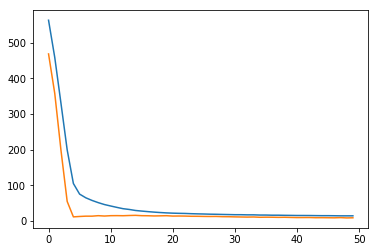

In [61]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [62]:
trainer.load_state('../../models/bostonhousing')

In [63]:
eval = trainer.evaluate(x_train,y_train)
eval

evaluate: 50/50 ok


{'losses': 13.577503126364922}

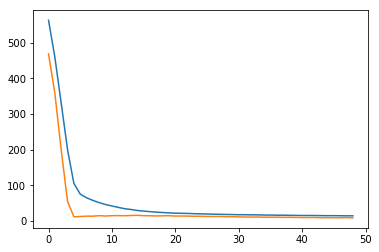

In [64]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [65]:
print('MSE:',valid_loss[-1])
print('RMSE:', np.sqrt(valid_loss[-1]))

MSE: 8.965329807786258
RMSE: 2.99421605897


# Exercícios

- Troque os hyperparâmetros para verificar se você consegue obter valores melhores. A forma de
  escolha e alteração de parâmetros é algo que se aprende com a experiência. Procure fazer
  sintonias finas, variando apenas um ou poucos parâmetros de cada vez.
  
  Parâmetros que podem ser trocados:
  - learning rate
  - n. de camadas
  - n. de neurônios
  - troca de função de ativação
  - método de otimizador do gradiente descendente
